### Содержание:  
<font size=4><ol>
<li>Получение и первичный анализ данных
    <ul>
        <li>1.1. Получение и осмотр данных</li>
        <li>1.2. Разведочный анализ данных</li>
    </ul>
</li>
<li>Преобразование признаков
    <ul>
        <li>2.1. Матрица линейного преобразования</li>
        <li>2.2. Проверка модели линейной регрессии</li>
    </ul>
</li>
<li>Выводы</li>
</ol></font>

---
## Выполнение проекта

### 1. Получение и первичный анализ данных

Импортируем необходимые библиотеки и модули для работы.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#### 1.1. Получение и осмотр данных

Получим данные, и ознакомимся с ними. Проверим типы данных в столбцах, наличие пропусков и дубликатов.

In [2]:
df = pd.read_csv('/datasets/insurance.csv')

display(df)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
df.duplicated().sum()

153

Пропусков нет, типы данных корректны. Есть дубликаты, но поскольку у нас нет идентификаторов клиентов, возможно в них попали клиенты с одинаковыми признаками.

#### 1.2. Разведочный анализ данных

Проверим корреляцию признаков.

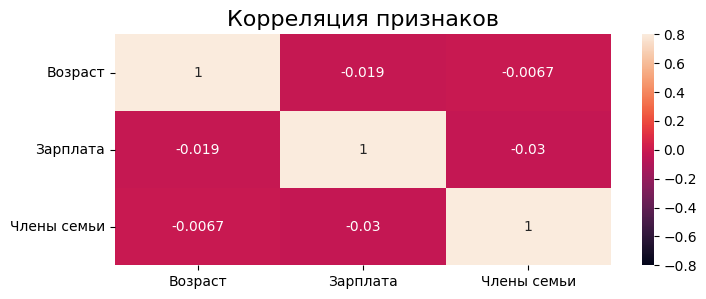

In [5]:
plt.figure(figsize=(8, 3))
sns.heatmap(df.drop(['Страховые выплаты', 'Пол'], axis=1).corr(), annot=True, vmin=-0.8, vmax=0.8)
plt.title('Корреляция признаков', fontsize=16)
plt.show()

Не выявлена.  
Теперь посмотрим на распределение клиентов по признаками.

Распределение значений по признакам


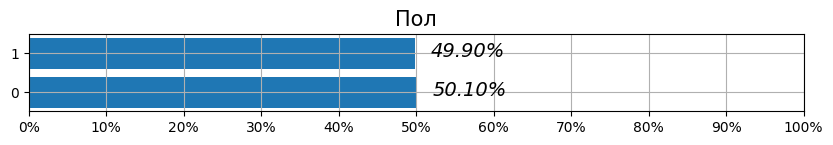

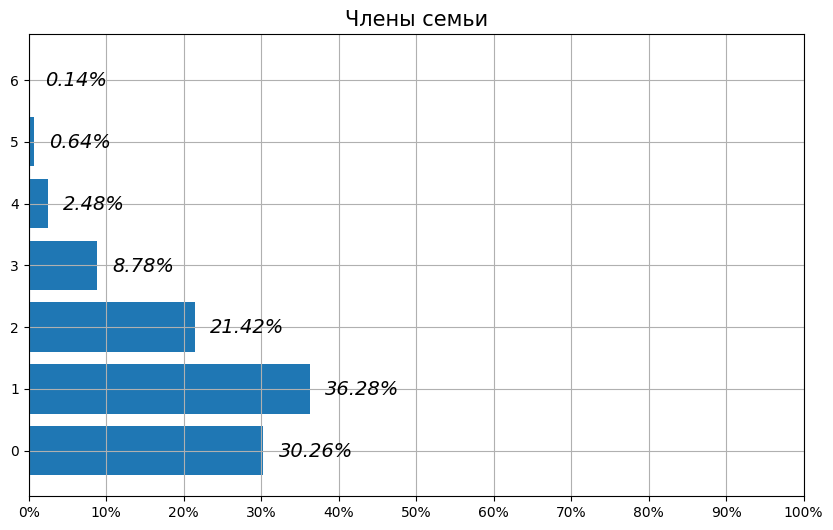

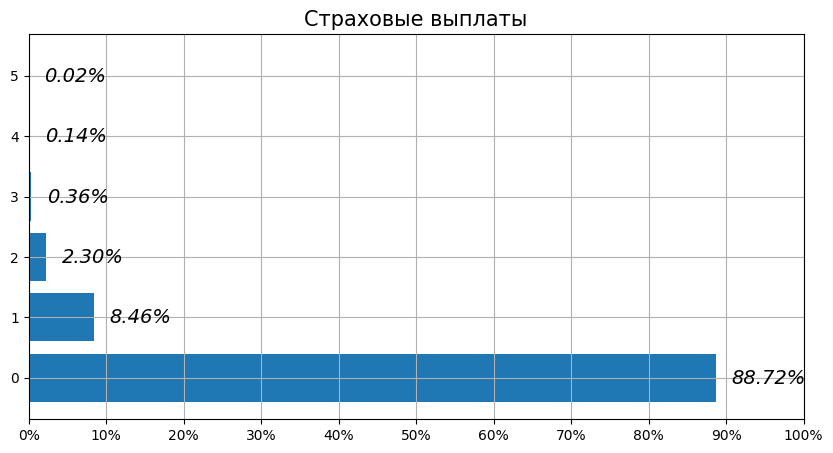

In [6]:
print('Распределение значений по признакам')

for i in ['Пол', 'Члены семьи', 'Страховые выплаты']:
    
    data = df[i].value_counts(normalize=True).reset_index().rename(columns={'index': i, i: 'Доля'})
    plt.figure(figsize=(10, data[i].max()))
    plt.title(i, fontsize=15)
    plt.barh(data=data, width=data['Доля'], y=i)
    plt.yticks([j for j in range(data[i].max() + 1)])
    plt.xticks([j for j in np.arange(0, 1.1, 0.1)], 
               ['{:.0%}'.format(j) for j in np.arange(0, 1.1, 0.1)])
    plt.grid(True)
    for j in range(data[i].nunique()):
        plt.text(x=data[data[i] == j]['Доля']+0.02, y=j-0.1, 
                 s='{:.2%}'.format(data[data[i] == j]['Доля'].unique()[0]), 
                 fontdict={'size': 14, 'style': 'oblique'})
    plt.show()

Пол распределен поровну, большинство клиентов имеет не более 2-х членов семьи, и почти 90% ни разу не получали страховые выплаты.

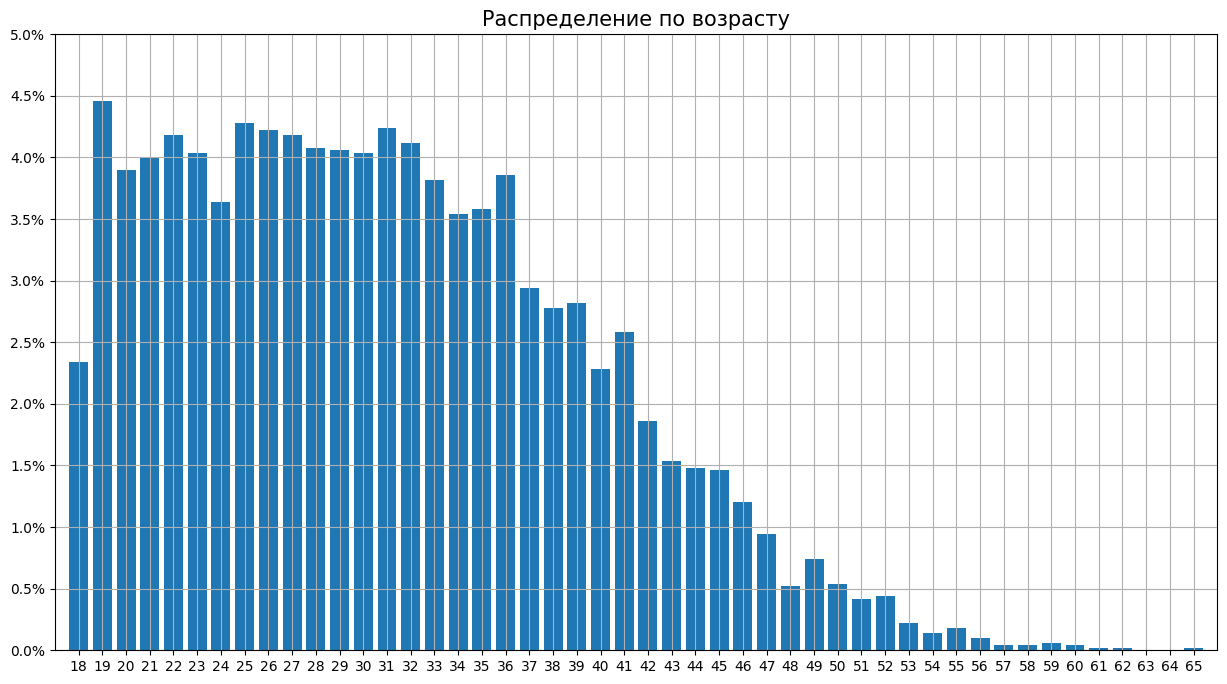

In [7]:
data = df['Возраст'].value_counts(normalize=True).reset_index().rename(columns={'index': 'Возраст', 'Возраст': 'Доля'})
plt.figure(figsize=(15, 8))
plt.title('Распределение по возрасту', fontsize=15)
plt.bar(data=data, height=data['Доля'], x='Возраст')
plt.xticks([j for j in range(data['Возраст'].astype('int64').min(), data['Возраст'].astype('int64').max() + 1)])
plt.yticks([j for j in np.arange(0, 0.055, 0.005)], 
           ['{:.1%}'.format(j) for j in np.arange(0, 0.055, 0.005)])
plt.xlim(data['Возраст'].astype('int64').min() - 1, data['Возраст'].astype('int64').max() + 1)
plt.grid(True)
plt.show()

Большинство клиентов имеет возраст до 40 лет.

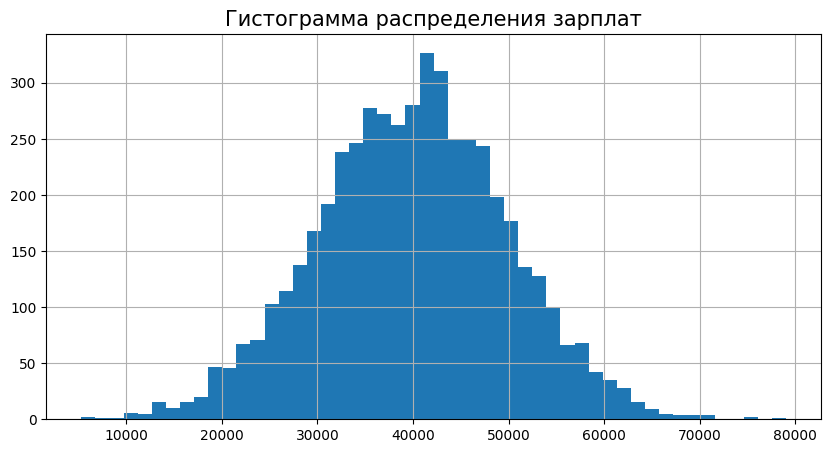

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(df['Зарплата'], bins=50)
plt.title('Гистограмма распределения зарплат', fontsize=15)
plt.grid(True)
plt.show()

Зарплаты клиентов распределены нормально. Среднее и медианное значения в районе 40 тыс.

### 2. Преобразование признаков

Для изменения признаков можно использовать линейное преобразование. То есть изменение всех векторов одинаковым образом.  
Для этого используют матрицу линейного преобразования. После такого преобразования, каждому вектору линейного пространства соответствует другой вектор того же пространства. В нашем случае каждому вектору-строке таблицы будет соответствовать другая вектор-строка такого же размера, при этом все векторы-строки изменятся одинаково, т.к. преобразование будет происходить по одному правилу.  
Для того чтобы вернуть значения к исходным, нужно совершить обратное преобразование с помощью матрицы, обратной матрице преобразования.  

Поэтому матрица линейного преобразования должна быть обратимой, чтобы можно было найти обратную матрицу, а для этого она должна быть квадратной, и при этом не вырожденной - то есть её определитель не должен быть равен нулю, вектора из которых она состоит должны быть линейно независимыми.
  
Попробуем сделать преобразование по максимальным значениям каждого признака. Для этого нам нужна матрица, размером с количество признаков исходного датасета, то есть (4x4). Поскольку строка из таблицы будет умножаться поочередно на каждый столбец, необходимо на каждом этапе умножения получать преобразование одного признака, при этом отбрасывая остальные. Этого можно добиться оставив в матрице линейного преобразования только главную диагональ. То есть фактически, получается матрица, которая растягивает или сжимает векторы вдоль координатных осей и меняет их норму (длину).

Докажем, что такое умножение не повлияет на расчеты.

Формула выглядит так: $w = (X^T X)^{-1} X^T y$
    
Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)    
    
Предсказания рассчитываются как  $a = Xw$
    
Мы умножаем матрицу признаков на обратимую квадратную матрицу $P$. Тогда результат такого умножения $R$, будет  $R = XP$

Тогда формула обучения $W$ для новой матрицы $R$ примет вид  $W = (R^T R)^{-1} R^T y$

Новое предсказание $A$ примет вид  $A = RW$

Докажем, что предсказания до и после будут равны.  
То есть, что  $a = A$    
    
Подставив $XP$ вместо $R$, получим  $W = ((XP)^T XP)^{-1}(XP)^T y$, следовательно: 

$$  
A = XPW = XP((XP)^T XP)^{-1}(XP)^T y = XP(XP)^{-1}((XP)^T)^{-1}P^T X^T y = XPP^{-1}X^{-1}(X^T)^{-1}(P^T)^{-1}P^T X^T y
$$
Поскольку умножение матрицы на обратную, даёт единичную матрицу $E$, а умножение матрицы $E$ на любую матрицу ничего не меняет, если только такое умножение возможно - а у нас оно возможно, поскольку единичные матрицы получены в результате умножения обратных и транспонированных вариантов квадратной матрицы $P$, изначально рассчитанной для умножения на матрицу $X$, а значит имеют такую же размерность как матрица $P$, получаем:
$$
XEX^{-1}(X^T)^{-1}EX^T y = X(X^T X)^{-1}X^T y = Xw = a
$$
Таким образом $A = a$.

#### 2.1. Матрица линейного преобразования

Создадим нулевую матрицу 4x4 и заполним главную диагональ максимальными значениями. Проверим обратимость такой матрицы.

In [9]:
lst = np.zeros([df.shape[1]-1, df.shape[1]-1])
cols = df.drop('Страховые выплаты', axis=1).columns
for i in range(len(lst)):
    lst[i][i] = df[cols[i]].max()
print(lst)
print(np.linalg.inv(lst))

[[1.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 6.5e+01 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 7.9e+04 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 6.0e+00]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.53846154e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.26582278e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.66666667e-01]]


Получилось. Обратная матрица вычисляется.

На всякий случай проверим, что размерность таблицы признаков после преобразования сохраняется.

In [10]:
print((df.drop('Страховые выплаты', axis=1).values @ lst).shape)

(5000, 4)


Отлично.

#### 2.2. Проверка модели линейной регрессии

При помощи уравнений линейной регрессии, в частности формулы поиска вектора коэффициентов, проверим как меняется вектор коэффициента после преобразования.  
Напишем функцию поиска вектора W, пользуясь формулой.

In [11]:
def find_w(features, target):
    return np.linalg.inv(features.T @ features) @ features.T @ target.values

Найдём вектор W до преобразования.

In [12]:
w_norm = find_w(df.drop('Страховые выплаты', axis=1).values, df['Страховые выплаты'])
print(w_norm.round(3))

[-0.044  0.023 -0.    -0.046]


Теперь найдём вектор W после преобразования.

In [13]:
w_trans = find_w(df.drop('Страховые выплаты', axis=1).values @ lst, df['Страховые выплаты'])
print(w_trans.round(3))

[-0.044  0.    -0.    -0.008]


Они мало чем отличаются, но на всякий случай вычислим расстояние между ними, и нормы самих векторов для сравнения.

In [14]:
print('Норма вектора до преобразования = {:.3f}'.format(np.linalg.norm(w_norm)))
print('Норма вектора после преобразования = {:.3f}'.format(np.linalg.norm(w_trans)))
print('Норма вектора разницы = {:.3f}'.format(np.linalg.norm(w_norm - w_trans)))

Норма вектора до преобразования = 0.068
Норма вектора после преобразования = 0.045
Норма вектора разницы = 0.044


Выглядит уже существеннее. Отличие практически на длину самого вектора.  
Попробуем оценить расстояние по-другому - найдём угол между этими векторами.

In [15]:
print('Угол между векторами коэффициентов W до и после преобразования равен {:.1f} градусов'.format(
      np.rad2deg(
                 np.arccos(
                           w_norm @ w_trans / np.linalg.norm(w_norm, 2) / np.linalg.norm(w_trans, 2)
                           )
                 )
                                                          )
      )

Угол между векторами коэффициентов W до и после преобразования равен 40.4 градусов


Это довольно существенно, то есть уже нельзя сказать что вектор практически не изменился.

Разобьём таблицу на матрицу признаков и вектор целевого признака и разделим их на обучающую и валидационную.

In [16]:
features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=123)
print('Размер обучающей выборки {}, размер тестовой выборки {}'.format(features_train.shape, features_valid.shape))

Размер обучающей выборки (3750, 4), размер тестовой выборки (1250, 4)


Разделение произошло корректно.

Напишем функцию, для обучения и тестирования модели линейной регрессии.

In [17]:
def linear_regression(features_train, features_valid, target_train, target_valid):

    model = LinearRegression()
    model.fit(features_train, target_train)
    predict_train = model.predict(features_train)
    predict_test = model.predict(features_valid)

    print('R2 линейной регрессии на обучающих данных {:.3f}'.format(r2_score(y_true=target_train, y_pred=predict_train)))
    print('R2 линейной регрессии на валидационных данных {:.3f}'.format(r2_score(y_true=target_valid, y_pred=predict_test)))

Проверим модель на исходных данных.

In [18]:
linear_regression(features_train, features_valid, target_train, target_valid)

R2 линейной регрессии на обучающих данных 0.423
R2 линейной регрессии на валидационных данных 0.430


Модель обучена успешно.

Теперь проверим модель на преобразованных признаках.  
Сначала проверим, что после обратного преобразования таблица возвращается в исходное состояние.

In [19]:
print('Исходная таблица')
display(features)

features_transform = features.values @ lst

print('Преобразованная таблица')
display(pd.DataFrame(data=features_transform, columns=features.columns))
print('Восстановленная таблица')
display(pd.DataFrame(data=features_transform @ np.linalg.inv(lst), columns=features.columns))

Исходная таблица


,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0
...,...,...,...,...
4995,0,28.0,35700.0,2
4996,0,34.0,52400.0,1
4997,0,20.0,33900.0,2
4998,1,22.0,32700.0,3


Преобразованная таблица


,Пол,Возраст,Зарплата,Члены семьи
0,1.0,2665.0,3.918400e+09,6.0
1,0.0,2990.0,3.002000e+09,6.0
2,0.0,1885.0,1.659000e+09,0.0
3,0.0,1365.0,3.294300e+09,12.0
4,1.0,1820.0,2.061900e+09,0.0
...,...,...,...,...
4995,0.0,1820.0,2.820300e+09,12.0
4996,0.0,2210.0,4.139600e+09,6.0
4997,0.0,1300.0,2.678100e+09,12.0
4998,1.0,1430.0,2.583300e+09,18.0


Восстановленная таблица


,Пол,Возраст,Зарплата,Члены семьи
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0
...,...,...,...,...
4995,0.0,28.0,35700.0,2.0
4996,0.0,34.0,52400.0,1.0
4997,0.0,20.0,33900.0,2.0
4998,1.0,22.0,32700.0,3.0


Значения в исходной таблице и в таблице после обратного преобразования совпадают.  
Теперь проверим корректность работы модели на преобразованных данных.

In [20]:
features_train_transform = features_train.values @ lst
features_valid_transform = features_valid.values @ lst

linear_regression(features_train_transform, features_valid_transform, target_train, target_valid)

R2 линейной регрессии на обучающих данных 0.423
R2 линейной регрессии на валидационных данных 0.430


Модель показывает такие же результаты как на исходных данных. Матрицу преобразования можно применять.

### 3. Выводы

Для преобразования данных можно использовать матрицу линейного преобразования.  
Такая матрица должна быть квадратной и не вырожденной. То есть её определитель не должен быть равен нулю, чтобы можно было найти обратную матрицу и совершить обратное преобразование.  
Размерность матрицы должна соответствовать количеству столбцов (признаков) в исходной матрице.  
Матрица должна быть диагональной, то есть все элементы не лежащие на главной диагонали должны быть равны нулю.  
Элементы главной диагонали в нашем случае равны максимальному значению соответствующего признака.  

Вероятно, если бы мы взяли не максимальное значение, а, скажем, среднее, это бы тоже сработало. Так же можно переименовать столбцы, чтобы окончательно запутать злоумышленников.  
Модель машинного обучения будет обучаться корректно, и видеть те же взаимосвязи. При этом вектор признаков W после преобразования изменился существенно, но не слишком сильно (норма вектора разности почти равна норме самого вектора коэффициентов, а отклонение на 40 градусов).